In [172]:
import sys
sys.path.append('../')
import importlib
import model
importlib.reload(model.op)
from model.op import number_aircrafts_lp

In [87]:
fix_cost = 1500000*0.7/10/365
variable_cost = 450/6

print('the fixed cost is:', fix_cost, 'variable cost is:', variable_cost)

the fixed cost is: 287.67123287671234 variable cost is: 75.0


### Compute load fatcor, passenger waiting time, and the metrics from the optimization problem, idle times for each aircraft, repositioning flights

Text(0, 0.5, '# of Aircrafts')

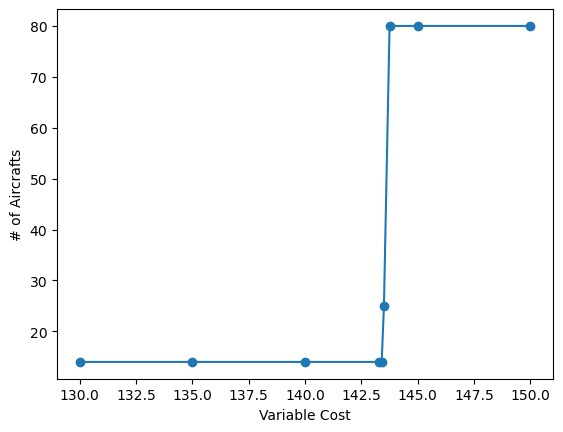

In [110]:
vc = [130, 135, 140, 143.3, 143.4, 143.5, 143.75, 145, 150]
n = [14, 14, 14, 14, 14, 25, 80, 80, 80]
plt.plot(vc,n,marker='o')
plt.xlabel('Variable Cost')
plt.ylabel('# of Aircrafts')

In [208]:
number_aircrafts_lp(schedule='schedule_10min_0608', schedule_time_step=288, output_path='testingfunction')

Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 11362 rows, 98940 columns and 205586 nonzeros
Model fingerprint: 0x880c8014
Variable types: 0 continuous, 98940 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1063 rows and 2606 columns
Presolve time: 0.17s
Presolved: 10299 rows, 96334 columns, 199792 nonzeros
Variable types: 0 continuous, 96334 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   37367    1.8025160e+01   0.000000e+00   1.949805e+04      5s
   70647    1.3146244e

In [163]:
tau = [[0, 5.92], [5.85, 0]]
tau = [[0, 10], [20, 0]]
kappa = [[0, 7.71875], [7.44375, 0]]

gamma = [1.567183013,1.670689686,1.79349788,1.935972287,2.103057098,
         2.30172949,2.541890384,2.83806663,3.212473781,3.70088931,
         4.364896382,5.32037536,6.814736187,9.490547548,15.74119426,55.66984127]

# gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091, 9.685271742, 16.30528373, 71.41103553]

number_aircrafts_lp(tau=tau, kappa=kappa, gamma=gamma, schedule='schedule_10min', schedule_time_step=288, output_path='testingfunction', fixed_cost=1, variable_cost=0.3)

Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 11438 rows, 99620 columns and 206980 nonzeros
Model fingerprint: 0x4dae1228
Variable types: 0 continuous, 99620 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 1062 rows and 2551 columns
Presolve time: 0.18s
Presolved: 10376 rows, 97069 columns, 201403 nonzeros
Variable types: 0 continuous, 97069 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   23340    9.4164600e+01   0.000000e+00   1.641080e+05      5s
   30996    6.6822542e

In [118]:
len(gamma)

16

In [56]:
(specificu['amount'].sum()*143.5*365*1.5 + 1500000*21)/365/1.5/

236.39518791710572

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

# Import Helper Functions

In [186]:
import ParseLP
importlib.reload(ParseLP)
from ParseLP import convert2df, calculate_num_aircrafts

# Testing

In [197]:
# output_file = 'variable_values'
output_file = 'testingfunction'
specificn, specificu, specificc = convert2df(output_file)

In [198]:
# Obtain Airport Specific Aircraft States
specificu01 = specificu[specificu['i'] == 0].reset_index(drop=True)
specificu10 = specificu[specificu['i'] == 1].reset_index(drop=True)

specificc01 = specificc[specificc['i'] == 0].reset_index(drop=True)
specificc10 = specificc[specificc['i'] == 1].reset_index(drop=True)

specificn01 = specificn[specificn['i'] == 0].reset_index(drop=True)
specificn10 = specificn[specificn['i'] == 1].reset_index(drop=True)

In [199]:
# Load Charging Time Array
gamma = [1.567183013,1.670689686,1.79349788,1.935972287,2.103057098,
         2.30172949,2.541890384,2.83806663,3.212473781,3.70088931,
         4.364896382,5.32037536,6.814736187,9.490547548,15.74119426,55.66984127]
# gamma = np.array(gamma) / 5
# gamma = np.ceil(gamma)
gamma = np.array(gamma)

In [200]:
lax_all_c, lax_all_n, lax_all_u = calculate_num_aircrafts(specificc01, specificu01, specificn01)
dtla_all_c, dtla_all_n, dtla_all_u = calculate_num_aircrafts(specificc10, specificu10, specificn10)
all_c, all_n, all_u = calculate_num_aircrafts(specificc, specificu, specificn)

# State Visulization

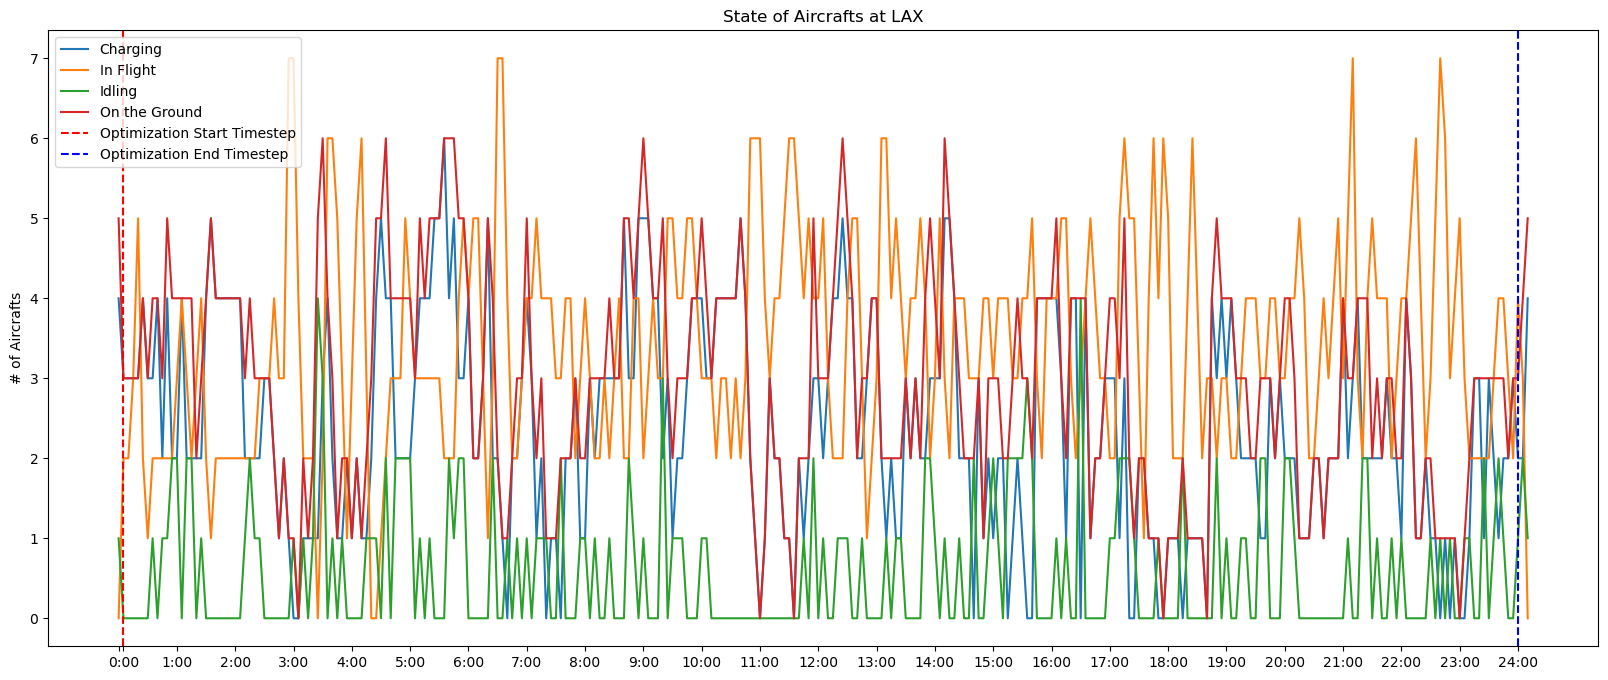

In [201]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(lax_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(lax_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(lax_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at LAX',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [202]:
print('At t = 0, c =', lax_all_c.sum(axis=0)[x0:x1][0], '; u=', lax_all_u.sum(axis=0)[x0:x1][0], '; n=', lax_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', lax_all_c.sum(axis=0)[x0:x1][290], '; u=', lax_all_u.sum(axis=0)[x0:x1][290], '; n=', lax_all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 4.0 ; u= 0.0 ; n= 1.0
At t = 290, c = 4.0 ; u= 0.0 ; n= 1.0


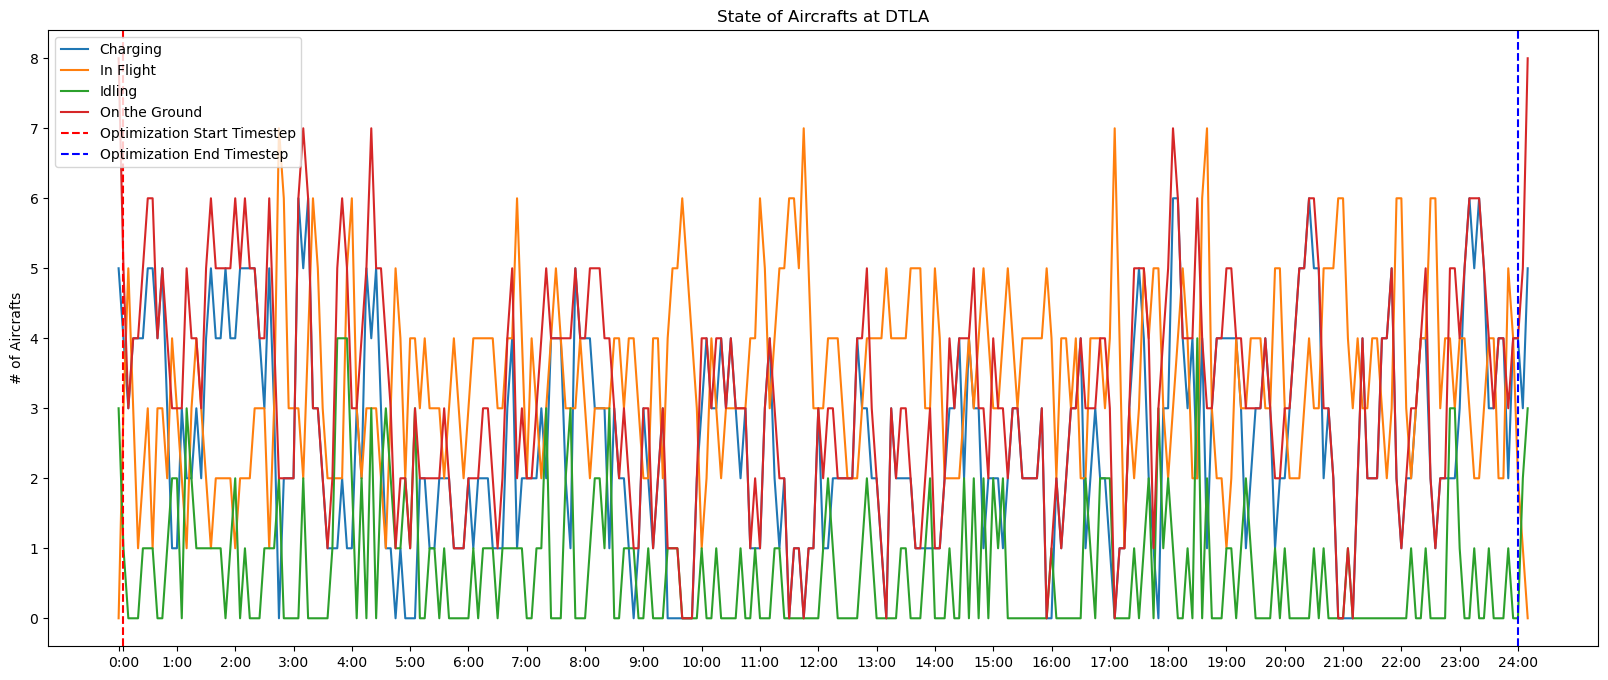

In [203]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(dtla_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(dtla_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(dtla_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at DTLA',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [204]:
print('At t = 0, c =', dtla_all_c.sum(axis=0)[x0:x1][0], '; u=', dtla_all_u.sum(axis=0)[x0:x1][0], '; n=', dtla_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', dtla_all_c.sum(axis=0)[x0:x1][290], '; u=', dtla_all_u.sum(axis=0)[x0:x1][290], '; n=', dtla_all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 5.0 ; u= 0.0 ; n= 3.0
At t = 290, c = 5.0 ; u= 0.0 ; n= 3.0


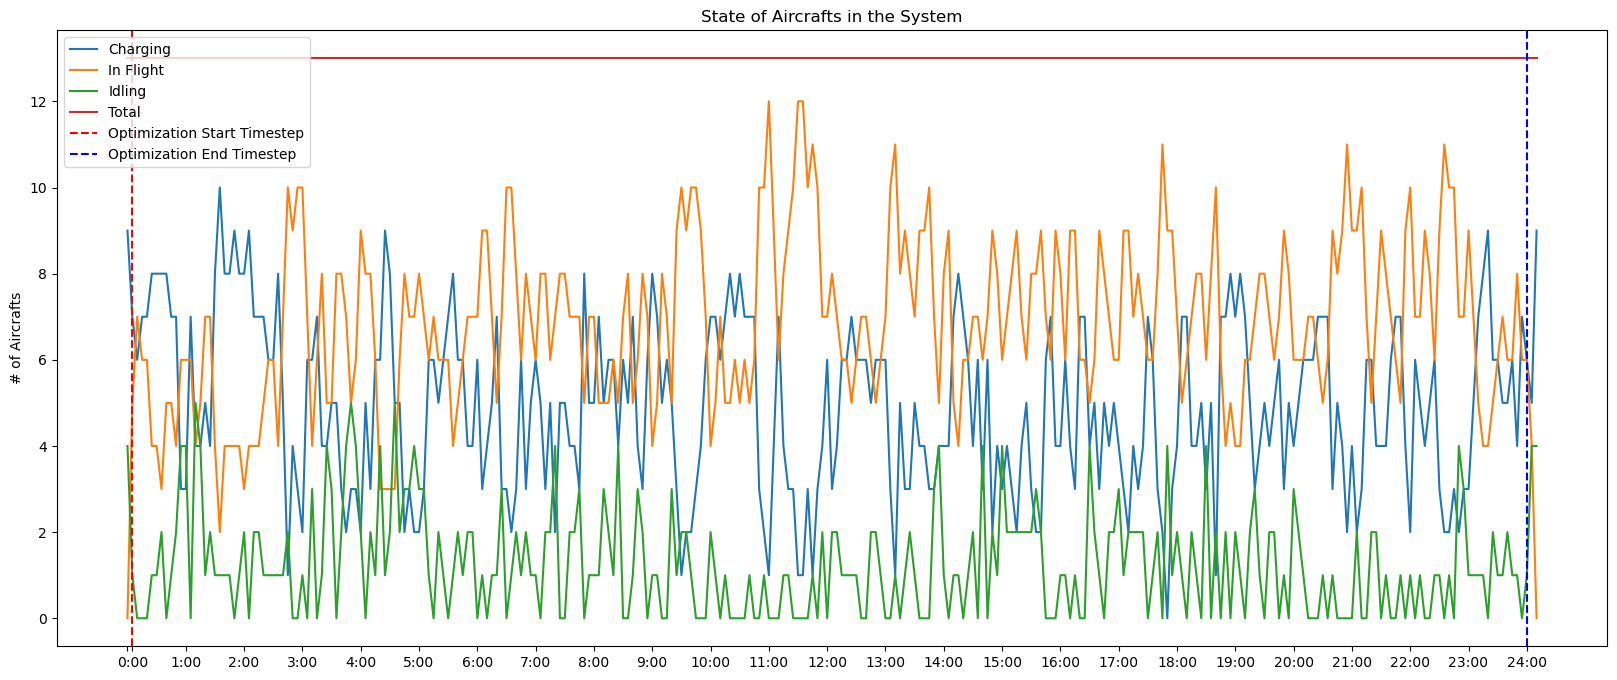

In [205]:
x0=0
x1=291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts in the System',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [206]:
print('At t = 0, c =', all_c.sum(axis=0)[x0:x1][0], '; u=', all_u.sum(axis=0)[x0:x1][0], '; n=', all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', all_c.sum(axis=0)[x0:x1][290], '; u=', all_u.sum(axis=0)[x0:x1][290], '; n=', all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 9.0 ; u= 0.0 ; n= 4.0
At t = 290, c = 9.0 ; u= 0.0 ; n= 4.0


# Cost Ratio Analysis

In [21]:
# A flight cost is 100 dollars, an aircraft is 2.2M


cost_ratio = np.array([0.3, 0.4, 0.5, 0.55, 0.6])
num_aircraft = np.array([12, 12, 19, 75, 75])

[Text(0.5, 0, 'Cost per Flight / Per Aircraft Ownership'),
 Text(0, 0.5, 'Minimum # of Aircrafts'),
 Text(0.5, 1.0, '# of Aircrafts Considering DOC ')]

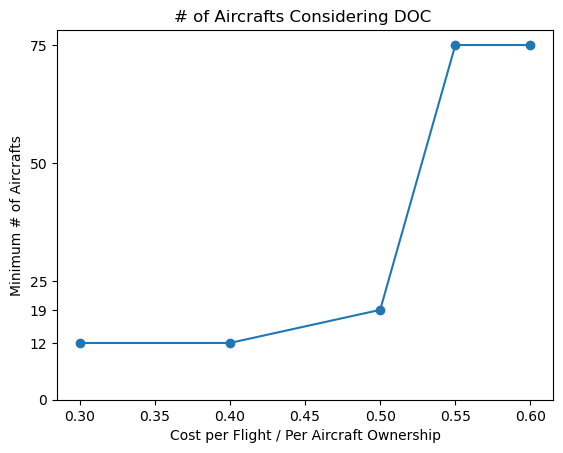

In [22]:
fig, ax = plt.subplots()
ax.plot(cost_ratio, num_aircraft, marker='o')
ax.set(yticks=[0,12,19,25,50,75])
ax.set(xlabel="Cost per Flight / Per Aircraft Ownership",
       ylabel='Minimum # of Aircrafts',
       title='# of Aircrafts Considering DOC ')

In [ ]:
381, 388

In [57]:
143.5/287

0.5